## Confirmation Bias Project
#### Behavioural analyses

##### Import important functions and libraries

In [1]:
import os, glob #pip install 

In [2]:
import os, glob #pip install 
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
#import scikit_posthocs as sp
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

/Users/alex/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Testing log regression by hand

In [3]:
# Tutorial followed as example https://uvastatlab.github.io/2019/05/04/simulating-a-logistic-regression-model/

x = np.linspace(-10,10,1000)
a = 2 # give a slope
b = 5 # give an intercept
y = (a * x) + b # linear function 
log_reg = lambda y: 1 / (1 + np.exp(-y)) # prob logistic reg
# generating probabilities
p = log_reg(y) 

# generating binomial data based on probabilities
yp  = np.random.binomial(1, p, len(p)) 

# Grouping data in dataframe
d = np.vstack((x,p,yp))
d = np.transpose(d)
d = pd.DataFrame(d, columns=['x', 'p', 'yp'])

# fitting model
f = "yp ~ x"
reg = smf.glm(formula = f, data = d, family=sm.families.Binomial()).fit()
print(reg.params)

PSE = - reg.params.Intercept/reg.params.x

# now look manually at the real curve (what is the PSE)

print(PSE)

Intercept    5.920275
x            2.328486
dtype: float64
-2.54254255460447


__Drawing the model__

Text(0.5, 1.0, 'Sigmoid Function')

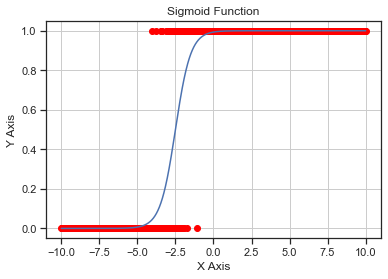

In [4]:
plt.plot(d.x,d.yp,'o', color = 'red', label='linspace(-10,10,100)')
plt.plot(d.x,d.p,'b', label='linspace(-10,10,100)')
plt.grid()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Sigmoid Function')
#plt.suptitle('Sigmoid')

In [ ]:
reg = smf.glm(formula = f, data = x).fit()
    params = reg.params
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]]})

##### Important functions

In [5]:
def RT_filter(x, sd): 
    # this function is used to filter those trials with a RT that it are below/above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x
def sdt_comp(x): # sdt is used to compute d' and c (even though, it is not used in these analyses)
    phit = x.loc[x.cond == 1,:].deci.mean()
    pfa  = x.loc[x.cond == 0,:].deci.mean() #correct condition to be 0 instead of -1
    # avoiding 0 or 1 probs that lead to infinite values
    if phit == 1: phit = phit - 0.0001
    if phit == 0: phit = phit + 0.0001
    if pfa == 1:  pfa = pfa - 0.0001
    if pfa == 0:  pfa = pfa + 0.0001
    # z transform the scores
    zhit = scipy.stats.norm.ppf(phit, loc=0, scale = 1) 
    zfa  = scipy.stats.norm.ppf(pfa, loc =0, scale = 1)
    dprime = zhit - zfa
    c = -(zhit + zfa)/2
    out = pd.concat([pd.Series(phit, name = "phit"), pd.Series(pfa, name = "pfa"), pd.Series(dprime, name = "dprime"), pd.Series(c, name = "c")], axis = 1)
    #out = out.reset_index()
    return out #dprime, c #
def log_reg_fit(x, f): # this function is used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]]})
    return out

### Data & variables

In [6]:
#results_path = 'C:/Users/usuario/Dropbox/ConfBiasProject/Analyses/results' #windows             
results_path = '/Users/alex/Dropbox/Projects/Condcision/Behav_data/FirstExperiment/' # mac

os.chdir(results_path) # change the current working directory to the results path 
rdata = pd.DataFrame([]) # concatenate general behav subject data
odata = pd.DataFrame([]) # concatenate here orientation stimuli (the matrix containing the 8 orientations x trial)
ddata = pd.DataFrame([]) # concatenate here orientation stimuli transformed to decision variable subject data (the matrix containing the 8 decisionvariables x trial)
ndata = pd.DataFrame([]) # useful when you named wrongly two datasets with the same name
coudf = pd.DataFrame([]) # concatenate files (alternative way to get the number of participants)
n_trials = 40*3 #trials * number of presentations
count = np.zeros(shape=(n_trials, 1)) #count = np.zeros(shape=(1, 1))
for file in glob.glob("*.psydat"): #si estuviera en un working directory por encima puedo hacer "./subject/*.psydat"
    p_file =  open(os.path.join(results_path, file),"rb")
    count = count + 1
    dat = pickle.load(p_file)
    coudf = pd.DataFrame(count, columns = ['npar'])
    for block in dat['main_exp']['Exp_blocks']:
        rdata = pd.concat([rdata,block['data']], axis = 0) #esta función es la que llena el dataframe con los valores de data
        odata = pd.concat([odata,block['trial_orientations']], axis = 0)
        ddata = pd.concat([ddata,pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])], axis = 0)
        ndata = pd.concat([ndata, coudf], axis = 0) #it provides the real number of participants (one file = one participant)
all_df = pd.concat([ndata, rdata, ddata, odata], axis = 1) #otro data frame con todos los data frames que interesan
all_df.tail()

npar subj  nblock  ntrial  nrep  cond   DV resp  r_map  correct     RT  \
115  29.0  p27       5      38     1    -1 -0.4    z      0        1  0.645   
116  29.0  p27       5      38     2    -1 -0.4    m     45        1  2.122   
117  29.0  p27       5      39     0    -1 -0.3    z      0        1  1.910   
118  29.0  p27       5      39     1    -1 -0.3    z      0        1  0.559   
119  29.0  p27       5      39     2    -1 -0.3    z      0        1  0.680   

           d1        d2        d3        d4        d5        d6     o1     o2  \
115 -0.432654 -0.427042  0.031843 -0.687820 -0.042524 -0.963831  1.348  0.225   
116 -0.432654 -0.427042  0.031843 -0.687820 -0.042524 -0.963831  1.348  0.225   
117 -0.397522 -0.131651 -0.872157  0.485116 -0.045589 -0.882862  2.905  0.341   
118 -0.397522 -0.131651 -0.872157  0.485116 -0.045589 -0.882862  2.905  0.341   
119 -0.397522 -0.131651 -0.872157  0.485116 -0.045589 -0.882862  2.905  0.341   

        o3     o4     o5     o6  
115  1.976  3.019  0.376  1.585  
116  1.976  3.019  0.376  1.585  
117  1.621  2.154  1.196  0.046  
118  1.621  2.154  1.196  0.046  
119  1.621  2.154  1.196  0.046

### Dataframe experiment 1

In [146]:
df = all_df
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

# Inserting the new necessary columns coding trials properly

df.insert(8, 'deci', 0)

# Criteria to code response type
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
#crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
all_df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(10, 'pre_deci', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'pre_correct', 0) # O = incorrect / 1 = correct
df.insert(10, 'rDV', 0)

# Insert the previous decision of each trial

df['pre_deci']  = df['deci'] #la variable pre_deci es igual al valor de deci
df['pre_deci'] = df['pre_deci'].shift(1, fill_value  = 0) # al hacer shift, se llena el primer valor con 0 

# Inserting mean DV per trial

df['rDV'] = np.mean(ddata, axis = 1)

# Insert the previous respose, if correct or not

df['pre_correct'] = df['correct']
df['pre_correct'] = df['pre_correct'].shift(1, fill_value  = 0)

df.insert(12, 'first_deci', 0)

df['first_deci']  = df['pre_deci'] #la variable pre_deci es igual al valor de deci
df['first_deci']  = df['first_deci'].shift(1, fill_value  = 0) # decision took 2 presentations earlier

df.insert(13, 'consistent', 0) #0 = none consistent / 1 = consistent

df.loc[(df.pre_deci == 0) & (df.first_deci == 0) | (df.pre_deci == 1) & (df.first_deci == 1), 'consistent'] = 1

df.insert(15, 'first_correct', 0)
df['first_correct']  = df['pre_correct']
df['first_correct'] = df['first_correct'].shift(1, fill_value  = 0) # result 2 presentations earlier

df.insert(16, 'both_correct', 0)
df.loc[(df.pre_correct == 1) & (df.first_correct == 1), 'both_correct'] = 1 # 0 = some errors at 2 previous

df.insert(17, 'congruent', 0)
df.loc[(df.pre_deci == 1) & (df.cond == 1) | (df.pre_deci == 0) & (df.cond == 0), 'congruent'] = 1

df.insert(17, 'both_incorrect', 0)
df.loc[(df.pre_correct == 0) & (df.first_correct == 0), 'both_incorrect'] = 1 # 1 = all errors at 2 previous

df.insert(18, 'first_error', 0)
df.loc[(df.first_correct == 0) & (df.pre_correct == 1), 'first_error'] = 1

df.insert(19, 'second_error', 0)
df.loc[(df.first_correct == 1) & (df.pre_correct == 0), 'second_error'] = 1

df.insert(21, 'repeat', 0)
df.loc[(df.deci == df.pre_deci), 'repeat'] = 1

df.insert(22, 'pre_repeat', 0)
df['pre_repeat']  = df['repeat'] 
df['repeat']  = df['repeat'].shift(1, fill_value  = 0) # al hacer shift, se llena el primer valor con 0

df.insert(23, 'repeat_all', 0)
df.loc[(df.deci == 0) & (df.pre_deci == 0) & (df.first_deci == 0) | (df.deci == 1) & (df.pre_deci == 1) & (df.first_deci == 1), 'repeat_all'] = 1

df.head(10) #da los 15 primeros outputs

npar subj  nblock  ntrial  nrep  cond    DV resp  deci  r_map       rDV  \
0   1.0  p14       0       0     0     0 -0.38    m     0     45 -0.366948   
1   1.0  p14       0       0     1     0 -0.38    z     0      0 -0.366948   
2   1.0  p14       0       0     2     0 -0.38    m     1      0 -0.366948   
3   1.0  p14       0       1     0     0 -0.28    m     0     45 -0.285548   
4   1.0  p14       0       1     1     0 -0.28    z     0      0 -0.285548   
5   1.0  p14       0       1     2     0 -0.28    m     0     45 -0.285548   
6   1.0  p14       0       2     0     1  0.18    z     1     45  0.184199   
7   1.0  p14       0       2     1     1  0.18    z     1     45  0.184199   
8   1.0  p14       0       2     2     1  0.18    z     1     45  0.184199   
9   1.0  p14       0       3     0     0 -0.08    m     1      0 -0.071730   

   pre_deci  first_deci  consistent  pre_correct  first_correct  both_correct  \
0         0           0           1            0              0             0   
1         0           0           1            1              0             0   
2         0           0           1            1              1             1   
3         1           0           0            0              1             0   
4         0           1           0            1              0             0   
5         0           0           1            1              1             1   
6         0           0           1            1              1             1   
7         1           0           0            1              1             1   
8         1           1           1            1              1             1   
9         1           1           1            1              1             1   

   both_incorrect  first_error  second_error  congruent  repeat  pre_repeat  \
0               1            0             0          1       0           1   
1               0            1             0          1       1           1   
2               0            0             0          1       1           0   
3               0            0             1          0       0           0   
4               0            1             0          1       0           1   
5               0            0             0          1       1           1   
6               0            0             0          0       1           0   
7               0            0             0          1       0           1   
8               0            0             0          1       1           1   
9               0            0             0          0       1           1   

   repeat_all  correct     RT        d1        d2        d3        d4  \
0           1        1  2.511 -0.581859 -0.985758  0.611403 -0.523808   
1           1        1  2.051 -0.581859 -0.985758  0.611403 -0.523808   
2           0        0  2.242 -0.581859 -0.985758  0.611403 -0.523808   
3           0        1  2.213  0.319595  0.563020 -0.220777 -0.691357   
4           0        1  1.528  0.319595  0.563020 -0.220777 -0.691357   
5           1        1  1.269  0.319595  0.563020 -0.220777 -0.691357   
6           0        1  1.332  0.507516 -0.006873 -0.019606  0.209578   
7           0        1  1.426  0.507516 -0.006873 -0.019606  0.209578   
8           1        1  1.664  0.507516 -0.006873 -0.019606  0.209578   
9           1        0  4.060 -0.016540  0.007368  0.316011 -0.947043   

         d5        d6     o1     o2     o3     o4     o5     o6  
0 -0.383752 -0.337915  1.735  3.136  0.938  0.187  0.242  0.260  
1 -0.383752 -0.337915  1.735  3.136  0.938  0.187  0.242  0.260  
2 -0.383752 -0.337915  1.735  3.136  0.938  0.187  0.242  0.260  
3 -0.825330 -0.858434  2.089  0.957  0.306  1.692  3.073  3.086  
4 -0.825330 -0.858434  2.089  0.957  0.306  1.692  3.073  3.086  
5 -0.825330 -0.858434  2.089  0.957  0.306  1.692  3.073  3.086  
6  0.245747  0.168834  0.592  0.390  0.385  0.475  2.060  0.459  
7  0.245747  0.168834  0.592  0.390  0.385  0.475 

### All participants are good or it is better to remove some??

In [147]:
print(np.unique(df.npar))
print( )
print("n subjects = " + str(len(np.unique(df.npar))))
print( )
print(list(df.columns))

formula = "deci ~ rDV"
log_par = df.groupby(['npar']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)


outliers = np.array(good_subjs)

mean = np.mean(outliers, axis=0)
sd = np.std(outliers, axis=0)

final_data = [x for x in outliers if (x > mean - 2 * sd)]
final_data = [x for x in final_data if (x < mean + 2 * sd)] # participants with 2+ sd from the mean were removed
print(final_data); print(len(final_data))

print( )
print("n good participants = " + str(len(final_data)))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]

n subjects = 29

['npar', 'subj', 'nblock', 'ntrial', 'nrep', 'cond', 'DV', 'resp', 'deci', 'r_map', 'rDV', 'pre_deci', 'first_deci', 'consistent', 'pre_correct', 'first_correct', 'both_correct', 'both_incorrect', 'first_error', 'second_error', 'congruent', 'repeat', 'pre_repeat', 'repeat_all', 'correct', 'RT', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6']
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0]
29

n good participants = 29


#### Let's remove bad participants

In [148]:
#Keeping only good subjects
df = df[df['npar'].isin(good_subjs)] 
df.reset_index(drop=True, inplace=True)
print(np.unique(df.npar)); print(len(np.unique(df.npar))) 
# Actually, we would not remove any of them, all of them were considere good

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
29


##### dflong

In [149]:
# new dataframe, it measures the particular effect by each stimuli position.
# it allows to measure the effect of each particular stimuli position in the final choice
# and to estimate if previous stimuli affect the final decision
dflong = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
del out

dflong.insert(6, 'expected', "U") 
# an stimuli is expected when the previous deci variable and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong.pre_deci == 0) & (dflong.dv < 0) | (dflong.pre_deci == 1) & (dflong.dv > 0), "expected"]  = "E"

dflong.insert(4, 'cond', "D")
dflong.loc[(dflong.dv < 0), "cond"]  = "C"

dflong.insert(8, 'pre_expected', "U")
dflong['pre_expected'] = dflong['expected']
dflong['pre_expected'] = dflong['pre_expected'].shift(1, fill_value = "U")

dflong.insert(9, 'cong_long', 0)
# one participant is congruent when the 2 last pre decis and deci variable were the same 
dflong.loc[(dflong.expected == 'U') & (dflong.pre_expected == 'U') | (dflong.expected == 'E') & (dflong.pre_expected == 'E'), 'cong_long'] = 1
#bins <- divids the orientation of the stimuli in small categories. it groups similar oriented stimuli together
dflong['bins'] = pd.cut(x=dflong['dv'], bins=[-0.55, -0.40, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.40, 0.55], labels=[-0.4, -0.30, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])

print(dflong.head())

formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)

   npar  nblock  ntrial  nrep cond  deci  pre_deci expected pre_expected  \
0   1.0       0       0     0    C     0         0        E            U   
1   1.0       0       0     1    C     0         0        E            E   
2   1.0       0       0     2    C     1         0        E            E   
3   1.0       0       1     0    D     0         1        E            E   
4   1.0       0       1     1    D     0         0        U            E   

   cong_long  pre_correct  correct  first_deci stim        dv  orient bins  
0          0            0        1           0   d1 -0.581859   1.735  NaN  
1          1            1        1           0   d1 -0.581859   1.735  NaN  
2          1            1        0           0   d1 -0.581859   1.735  NaN  
3          1            0        1           0   d1  0.319595   2.089  0.3  
4          0            1        1           1   d1  0.319595   2.089  0.3  


### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [150]:
# In this chunk, we will compute two important things. We will group stimuli depending on their similar orientation
# compared with the orientation of the previous stimuli and also, we will group stimuli depending on the previous
# category. Two stimuli would be grouped together if they were preceded by a stimuli from the same category (Diag follwd Diag)

# selecting the stimuli Dv
stim_dec = df[['d1','d2','d3','d4','d5','d6']]
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0

diff_stim_dec = np.diff(stim_dec, axis  = 1)
out = abs(pd.DataFrame(diff_stim_dec, index = df.index, columns = ["cd2","cd3","cd4","cd5","cd6"]))

# resetting indexes in order to be able to concatenate the dataframes 
out.reset_index(drop=True, inplace=True)

# concatenating vertically (over columns)
df.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=['cd2', 'cd3', 'cd4', 'cd5', 'cd6'])
out.head()
# dataset removing first stimulus of the sequence in order to append whether the previous stim is congruent or incongruent
dflong_sd = dflong.loc[dflong.stim != "d1", : ]
dflong_sd.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
dflong_sd = pd.concat([dflong_sd, out.value], axis = 1)

dflong_sd.rename(columns = {'value' : 'pre_stim'}, inplace = True)
#print(dflong_sd.loc[ (dflong_sd.nblock == 1) & (dflong_sd.ntrial == 0) & (dflong_sd.subj == "p01"),:])

#Appending information about the physical difference between the pre-stimulus and current orientation (classifyin in similar & different physically)

stim_ori = df[['o1','o2','o3','o4','o5','o6']]

diff_stim_ori = abs(np.diff(np.rad2deg(stim_ori), axis  = 1))
diff_stim_ori[diff_stim_ori < 67.5] = 0
diff_stim_ori[diff_stim_ori > 67.5] = 1
diff_stim_ori
out = abs(pd.DataFrame(diff_stim_ori, columns = ["co2","co3","co4","co5","co6"]))
#out.head(200)
# concatenating vertically (over columns)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=["co2","co3","co4","co5","co6"])
out.rename(columns = {'value' : 'pre_orient'}, inplace = True) # if the difference is smaller than 67.5 degrees the stimuli are assumed to be similar

dflong_sd = pd.concat([dflong_sd, out.pre_orient], axis = 1)
dflong_sd.head()

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/alex/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2983: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

npar  nblock  ntrial  nrep cond  deci  pre_deci expected pre_expected  \
0   1.0       0       0     0    C     0         0        E            E   
1   1.0       0       0     1    C     0         0        E            E   
2   1.0       0       0     2    C     1         0        E            E   
3   1.0       0       1     0    D     0         1        E            E   
4   1.0       0       1     1    D     0         0        U            E   

   cong_long  pre_correct  correct  first_deci stim        dv  orient bins  \
0          1            0        1           0   d2 -0.985758   3.136  NaN   
1          1            1        1           0   d2 -0.985758   3.136  NaN   
2          1            1        0           0   d2 -0.985758   3.136  NaN   
3          1            0        1           0   d2  0.563020   0.957  NaN   
4          0            1        1           1   d2  0.563020   0.957  NaN   

   pre_stim  pre_orient  
0       0.0         1.0  
1       0.0         1.0  
2       0.0         1.0  
3       0.0         0.0  
4       0.0         0.0

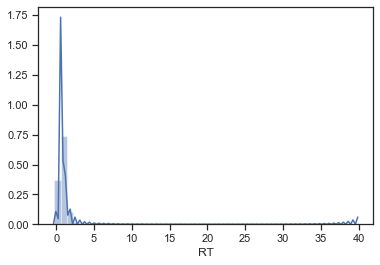

In [151]:
sns.axes_style('white') #RTs
sns.distplot(df.RT)

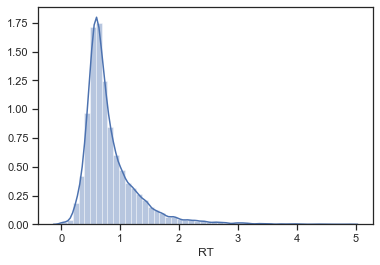

In [152]:
# RT after apply filter
df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 3) #1.5 responses larger 1.5 were removed
sns.distplot(df.RT)

#### Plots experiment 1

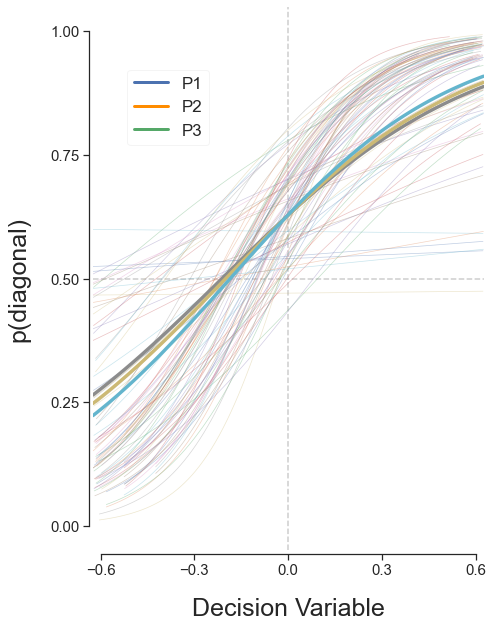

In [153]:
# Repeating the same sequence of stimuli makes the participants' estimation more similar to the real average of the sequence?
# Puede que le tengas que dar a run dos veces para que te haga bien el plot, los colores a lo mejor te salen mal
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["b", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject
for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.savefig('deci_x_nrep.png')


In [154]:
# make the model to estimate if there are statistical differences at the slope (weight) or the intercept of the last plot
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.head()

npar  nrep  level_2  intercept    weight
0   1.0     0        0   0.078051  4.622432
1   1.0     1        0   0.439806  6.324326
2   1.0     2        0   0.137837  5.587118
3   2.0     0        0   0.502546  4.811019
4   2.0     1        0   0.580930  4.756625

In [155]:
aov_nrep = AnovaRM(log_reg_nrep, 'weight', 'npar', within = ['nrep']).fit() #se rechaza H0
print(aov_nrep)
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)
#Alexis, el W-spher es el p-value de sphericity? Porque si es así, no hay que hacer la corrección

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
nrep 12.5530 2.0000 56.0000 0.0000



Source      SS  DF     MS       F        p-unc    p-GG-corr   np2    eps  \
0   nrep   6.318   2  3.159  12.553  3.13181e-05  6.35689e-05  0.31  0.906   
1  Error  14.093  56  0.252       -            -            -     -      -   

  sphericity W-spher   p-spher  
0       True   0.897  0.229213  
1          -       -         -

__AQUI FALTA:__

Plotear los parametros bias y weight en diferentes figuras, media del grupo y de cada sujeto para condicion. Adenás faltarían los post-hoc t-tests porque sabemos que hay un main efecto de repeticion para weights, pero no sabemos que lo esta causando. El pinguin creo que te lo hace todo al correr el anova. Además también te da valores como el tamaño del efecto, bayes factor, etc.

In [156]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'intercept', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

Source     SS  DF     MS      F     p-unc p-GG-corr    np2    eps  \
0   nrep  0.010   2  0.005  0.265  0.768462  0.760601  0.009  0.964   
1  Error  1.047  56  0.019      -         -         -      -      -   

  sphericity W-spher   p-spher  
0       True   0.963  0.602325  
1          -       -         -

/Users/alex/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning:

invalid value encountered in true_divide



Text(0, 0.5, '')

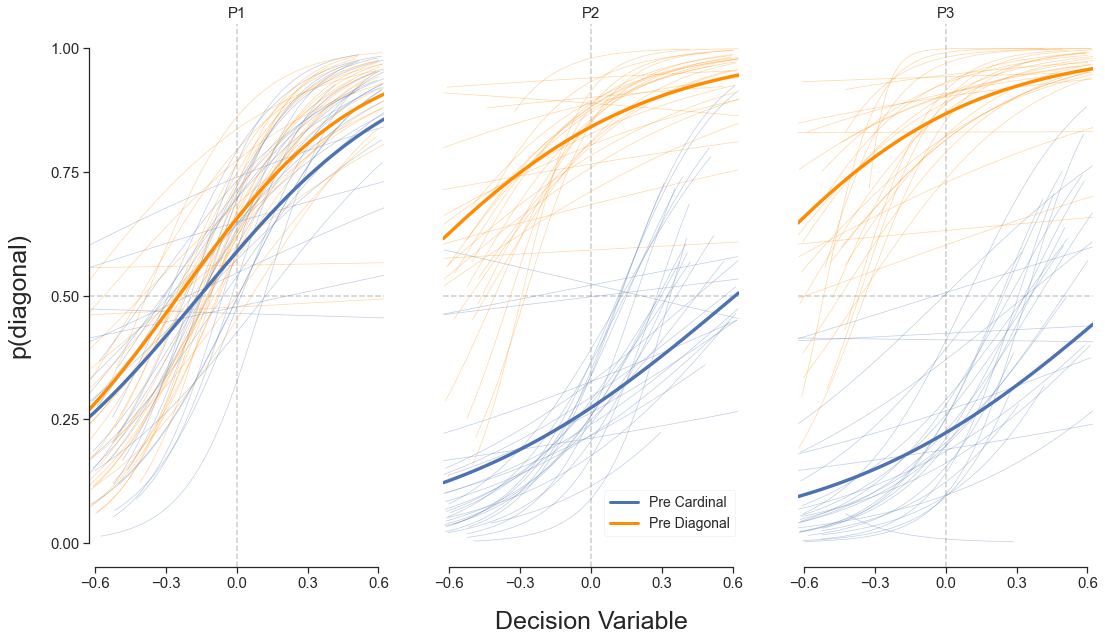

In [157]:
# Previous decisions biases the next response? Previous decision might bias how we estimate the next presentation
# of the trial. Let's find out if previous cardinal decision generates different probabilities to answer diagonal 
# compared with when they previously responded diagonal to equivalent sequences

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
plt.subplots(ncols=2, figsize=(18, 10))
mycol = ["b", "darkorange"]
sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)
plt.subplot(1, 3, 1)
ax0 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax0 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P1
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax0 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 0),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average for P1
    ax0 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 0),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = at lest 1 incorrect answers in this trial ; 1 = both previous answers correct
sns.despine(ax= ax0, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15); plt.title('P1', fontsize= 15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; #plt.legend(lines, labels, bbox_to_anchor=(0.49,0.15), fontsize=14, framealpha= 0.2)

plt.subplot(1, 3, 2)
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P2
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 1),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #this for loop makes the plot for each participant for P2
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 1),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax1, offset=0, trim=True);
sns.despine(ax=ax1, left=True)
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.title('P2', fontsize= 15); plt.yticks([], []); plt.ylabel('', fontsize = 0)
plt.legend(lines, labels, bbox_to_anchor=(0.52,0.1), fontsize=14, framealpha= 0.2)


plt.subplot(1, 3, 3)
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P3
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #this for loop makes the plot for each participant for P3
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
#sns.despine(left=True);
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True)
plt.title('P3', fontsize=15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.yticks([], []); plt.xlabel(' ', fontsize = 0); plt.ylabel('', fontsize = 0)
#sns.despine(ax=ax, right=True, left=True)
#plt.savefig('predeci.png')

In [158]:
# The differences in the previous plot are significant?
formula = "deci ~ rDV"
log_reg_preDeci = df.groupby(['npar', 'nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head()

npar  nrep  pre_deci  level_3  intercept    weight
0   1.0     0         0        0  -0.732209  6.261033
1   1.0     0         1        0   0.699476  4.106894
2   1.0     1         0        0  -0.670820  4.442537
3   1.0     1         1        0   1.723281  6.213018
4   1.0     2         0        0  -1.713333  4.308909

In [159]:
aov_nrep = AnovaRM(log_reg_preDeci, 'weight', 'npar', within = ['nrep', 'pre_deci']).fit() #se rechaza H0
print(aov_nrep)
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)
#Alexis, el W-spher es el p-value de sphericity? Porque si es así, no hay que hacer la corrección. Cogería el valor de 'p-unc', no?

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
nrep           5.4730 2.0000 56.0000 0.0067
pre_deci       0.6079 1.0000 28.0000 0.4421
nrep:pre_deci  0.9811 2.0000 56.0000 0.3812



Source      SS  ddof1  ddof2     MS      F     p-unc  p-GG-corr  \
0             nrep  12.920      2     56  6.460  5.473  0.006745   0.013828   
1         pre_deci   4.042      1     28  4.042  0.608  0.442129   0.442129   
2  nrep * pre_deci   8.409      2     56  4.204  0.981  0.381249   0.353648   

     np2    eps  
0  0.164  0.738  
1  0.021  1.000  
2  0.034  0.674

In [160]:
#Checking statistical differences in Intercept between the number of repetitions & previous decision
pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)

Source       SS  ddof1  ddof2       MS        F         p-unc  \
0             nrep    0.727      2     56    0.364    1.998  1.452149e-01   
1         pre_deci  209.772      1     28  209.772  125.589  7.348256e-12   
2  nrep * pre_deci   89.443      2     56   44.722   73.094  2.444195e-16   

      p-GG-corr    np2    eps  
0  1.471823e-01  0.067  0.962  
1  7.348256e-12  0.818  1.000  
2  7.947564e-11  0.723  0.608

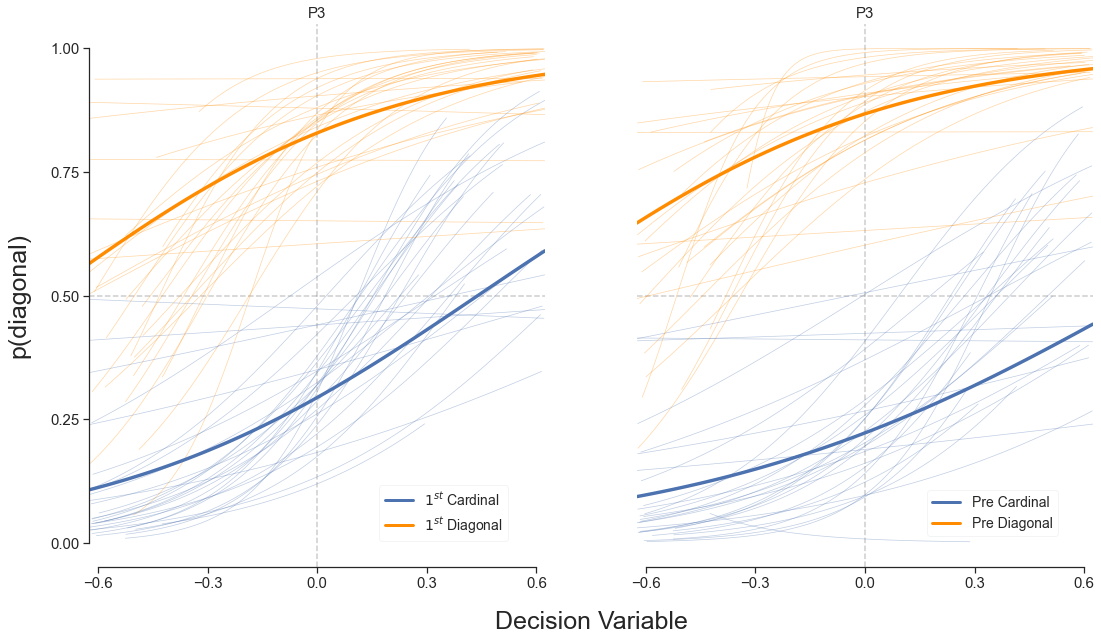

In [161]:
# First decisions biases the response at the 3rd presentation? If participants respond diagonal in the first presentation,
# they would be also biased to answer diagonal in the last presentation? 

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
fig = plt.subplots(ncols=2, figsize=(18, 10))
mycol = ["b", "darkorange"]
sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)
fig = plt.subplot(1, 2, 1) #if participants decision at P1 biases the response at P3
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.first_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average by all the sample
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.first_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = at lest 1 incorrect answers in this trial ; 1 = both previous answers correct
sns.despine(ax= ax1, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15); plt.title('P3', fontsize= 15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['$1^{st}$ Cardinal', '$1^{st}$ Diagonal']; #plt.legend(lines, labels, bbox_to_anchor=(0.49,0.15), fontsize=14, framealpha= 0.2)
plt.legend(lines, labels, bbox_to_anchor=(0.62,0.1), fontsize=14, framealpha= 0.2); plt.xlabel('Decision Variable', x=1.1, fontdict={'size':25}, labelpad=20); 

fig = plt.subplot(1, 2, 2) #if participants decision at P1 biases the response at P3
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average by all the sample
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True);
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; plt.title('P3', fontsize= 15);
plt.legend(lines, labels, bbox_to_anchor=(0.62,0.1), fontsize=14, framealpha= 0.2); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.yticks([], []); plt.ylabel('', fontsize = 0); plt.xlabel('', x=1.1, fontdict={'size':1}, labelpad=1); 

#plt.savefig('first_deci_pre_deci_afect_3rdpresenation.png')

In [162]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
formula = "deci ~ rDV"
log_reg_pre_first = df.loc[df.nrep == 2,:].groupby(['npar', 'first_deci']).apply(log_reg_fit, formula) 
log_reg_pre_first.reset_index(inplace = True)
log_reg_pre_first.head()

npar  first_deci  level_2  intercept    weight
0   1.0           0        0  -0.649410  4.194692
1   1.0           1        0   0.896881  4.833620
2   2.0           0        0  -0.826040  7.443447
3   2.0           1        0   1.856951  1.352142
4   3.0           0        0  -1.160000  5.101217

In [163]:
#Checking statistical differences in Weight between the number of repetitions & the first decision
pg.rm_anova(dv = 'weight', within = ['first_deci'], subject = 'npar', data=log_reg_pre_first, detailed = True, correction = True)

Source      SS  DF     MS      F     p-unc np2 eps
0  first_deci   0.002   1  0.002  0.001  0.979801   0   1
1       Error  68.908  28  2.461      -         -   -   -

__Que significan los resultados en general? t.tests. Tendría que haber interaccion en el anova tambien, no? es decir, meter pre_deci en el analisis__

In [164]:
#Checking statistical differences in Intercept between the number of repetitions & the first decision
pg.rm_anova(dv = 'intercept', within = ['first_deci'], subject = 'npar', data=log_reg_pre_first, detailed = True, correction = True)

Source      SS  DF      MS        F        p-unc    np2 eps
0  first_deci  94.736   1  94.736  165.653  2.80455e-13  0.855   1
1       Error  16.013  28   0.572        -            -      -   -

#### Plots experiment 1: long

In [165]:
# The next model checks if stimuli are weigthed/change their intercept depending on the category of previous
# stimuli inside a sequence. For example, if a stimuli is followed from another stimui from the same category,
# for example (diagonal stimuli followed by another diagonal stimuli), the second diagonal stimuli can be 
# weighted more compared when it was preceded by a cardinal stimuli
formula = "deci ~ dv"

log_regpre_deci_params = dflong_sd.groupby(['npar', 'nrep', 'pre_stim']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

npar  nrep  pre_stim  level_3  intercept    weight
0   1.0     0       0.0        0   0.308388  1.430543
1   1.0     0       1.0        0  -0.112966  0.161207
2   1.0     1       0.0        0   0.459819  1.767577
3   1.0     1       1.0        0   0.200236  0.250002
4   1.0     2       0.0        0   0.207368  1.689094

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

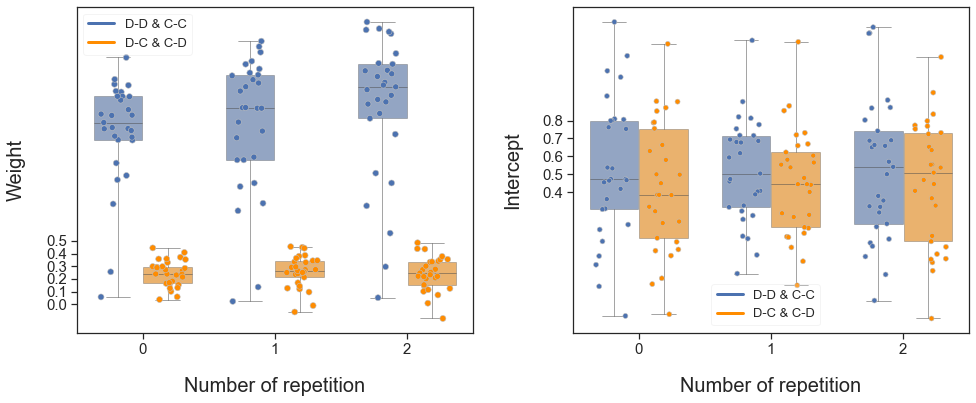

In [166]:
#These subplots are the original plots with seaborn. The next ones, are the plots improved using Plolty
plt.subplots(ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace = 0.25)
dat = log_regpre_deci_params
mycol = ['b', 'darkorange']
plt.subplot(1, 2, 1)  

ax = sns.boxplot(x="nrep", y="weight", hue = dat.pre_stim, linewidth = 0.5, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="weight", hue = dat.pre_stim, dodge=True, jitter = .25, data=dat, linewidth =.55, size=6, marker="o", edgecolor="silver", alpha=1, palette = mycol)
plt.ylabel('Weight', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 0.51, step=0.1), fontsize = 15)
plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['D-D & C-C', 'D-C & C-D']; plt.legend(lines, labels, loc= 'upper left', fontsize=13, framealpha= 0.2)

plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
ax = sns.boxplot(x="nrep", y="intercept", hue = dat.pre_stim, linewidth = 0.5, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="intercept", hue = dat.pre_stim, dodge=True, jitter = .25, data=dat, linewidth =.55, size=5, marker="o", edgecolor="silver", alpha=1, palette = mycol)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['D-D & C-C', 'D-C & C-D']; plt.legend(lines, labels, bbox_to_anchor=(0.64,0.17), fontsize=13, framealpha= 0.2)
plt.ylabel('Intercept', fontsize = 20, labelpad=20); plt.yticks(np.arange(0.4, 0.81, step=0.1), fontsize = 15); plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)

__ME GUSTAN ESTOS PLOTS, DE TODAS MANERAS HABRÏA QUE HACER PLOTS COMO ESTOS PERO TAMBIEN DE LOS GRAFICOS ANTERIORES__ 

Faltan anovas y t-tests. Falta explicar que signidican estos resultados.

### Plots that represent differences inside the trials 

In [167]:
# Stimulus following one from the same category (i.e. Diagonal & Diagonal) are weighted more than others
# preceded by stimuli from different categories?

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#2A88D4'))
#0A4893

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#FA920A'
))

fig.update_layout(
    yaxis_title='Weight',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    yaxis_title="Weight",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

No consigo ver nada de lo que hay arriba

In [168]:
#Checking statistical differences in Weight between the number of repetitions & the previous stimulus
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

aov_preor_weight = AnovaRM(log_regpre_deci_params, 'weight', 'npar', within = ['nrep', 'pre_stim']).fit()
#print(aov_preor_weight) 
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_stim'], subject = 'npar', data=log_regpre_deci_params, detailed = True, correction = True)

Source      SS  ddof1  ddof2      MS        F         p-unc  \
0             nrep   0.273      2     56   0.137    7.545  1.254987e-03   
1         pre_stim  62.629      1     28  62.629  214.477  1.186025e-14   
2  nrep * pre_stim   0.316      2     56   0.158   13.742  1.394180e-05   

      p-GG-corr    np2    eps  
0  1.569288e-03  0.212  0.947  
1  1.186025e-14  0.885  1.000  
2  2.080347e-05  0.329  0.952

No hay diferencias? No se exactamente que es lo que intentas ver aquí, number of repetition x previois stimulus ya lo has testeado mas arriba, nop? Y salia que había efectos de weight. Imagino que habría que mneter si son same or different category, por ejemplo. Aqui tiene que haber efectos como se ve claramente en la figura DD & CC vs DC & CD

In [169]:
# The same as before, with intercept instead of weight.
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#2A88D4')) #2A88D4
#1C72E2

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#FA920A'
))

fig.update_layout(
    yaxis_title='Weight',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [170]:
#Checking statistical differences in Intercept between the number of repetitions & the orientation of the previous stimulus

aov_preor_inter = AnovaRM(log_regpre_deci_params, 'intercept', 'npar', within = ['nrep', 'pre_stim']).fit()
print(aov_preor_inter)
pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', data=log_regpre_deci_params, detailed = True, correction = True)

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
nrep           0.0449 2.0000 56.0000 0.9562
pre_stim       7.5919 1.0000 28.0000 0.0102
nrep:pre_stim  0.4946 2.0000 56.0000 0.6124



Source     SS  ddof1  ddof2     MS      F     p-unc  p-GG-corr  \
0             nrep  0.002      2     56  0.001  0.045  0.956152   0.952765   
1         pre_stim  0.262      1     28  0.262  7.592  0.010192   0.010192   
2  nrep * pre_stim  0.004      2     56  0.002  0.495  0.612443   0.602559   

     np2    eps  
0  0.002  0.971  
1  0.213  1.000  
2  0.017  0.947

In [171]:
# The next model checks if stimuli are weigthed/change their intercept depending on the orientation of previous
# stimuli inside a sequence. For example, a stimuli following another with similar orientation can be weighted 
# more or less than when the stimuli is following another with different orientation. 

formula = "deci ~ dv"

log_regpre_orient_params = dflong_sd.groupby(['npar', 'nrep', 'pre_orient']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

npar  nrep  pre_orient  level_3  intercept    weight
0   1.0     0         0.0        0  -0.046878  0.682776
1   1.0     0         1.0        0   0.317338  1.020110
2   1.0     1         0.0        0   0.279210  0.725937
3   1.0     1         1.0        0   0.392119  1.422905
4   1.0     2         0.0        0   0.097503  0.718478

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

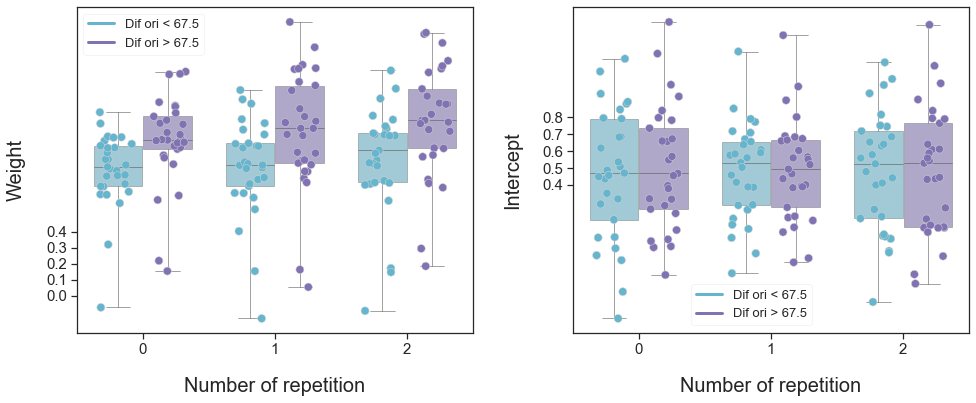

In [172]:
plt.subplots(ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace = 0.25)
dat = log_regpre_orient_params
mycol = ['c', 'm']
plt.subplot(1, 2, 1)  

ax = sns.boxplot(x="nrep", y="weight", hue = dat.pre_orient, linewidth = 0.55, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="weight", hue = dat.pre_orient, dodge=True, jitter=.25, data=dat, linewidth =.5, size=8, marker="o", edgecolor="lightgrey", alpha=1, palette = mycol)
plt.ylabel('Weight', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 0.41, step=0.1), fontsize = 15)
plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Dif ori < 67.5', 'Dif ori > 67.5']; plt.legend(lines, labels, loc= 'upper left', fontsize=13, framealpha= 0.2)
                                                                            
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
ax = sns.boxplot(x="nrep", y="intercept", hue = dat.pre_orient, linewidth = 0.55, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="intercept", hue = dat.pre_orient, dodge=True, jitter=.25, data=dat, linewidth =.5, size=8, marker="o", edgecolor='lightgrey', alpha=1, palette = mycol)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Dif ori < 67.5', 'Dif ori > 67.5']; plt.legend(lines, labels, bbox_to_anchor=(0.62,0.17), fontsize=13, framealpha= 0.2)
plt.ylabel('Intercept', fontsize = 20, labelpad=20); plt.yticks(np.arange(0.4, 0.81, step=0.1), fontsize = 15); plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
#plt.savefig('Orinetation_pre.png')

In [173]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented in degrees
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Dif ori < 67.5', # Stimuli followed by another similar in orientation
    marker_color='#3FBFAA'))
#0A4893

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Dif ori > 67.5', # Stimuli followed by another very different in orientation
    marker_color='#9F68E3' #violeta
))

fig.update_layout(
    yaxis_title='Weight',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0, 0.1, 0.2, 0.3], ticktext=['0','0.1', '0.2', '0.3'])

fig.update_layout(
    yaxis_title="Weight",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

Por alguna razón no me deja ver estas figuras. Si puedes hazme un copy paste de la imagen. Por cierto, creo que las dos condiciones son orientacion fisica similar o distinta. En estos resultados me parece que salia que la gente le daba mas peso a los estimulos cuando eran fisicamente distintos.

In [174]:
#Checking statistical differences in Weight between the number of repetitions & the orientation of the previous stimulus

aov_preor_weight = AnovaRM(log_regpre_orient_params, 'weight', 'npar', within = ['nrep', 'pre_orient']).fit()
print(aov_preor_weight) 

pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_orient'], subject = 'npar', data=log_regpre_orient_params, detailed = True, correction = True)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
nrep             7.2822 2.0000 56.0000 0.0015
pre_orient      40.8714 1.0000 28.0000 0.0000
nrep:pre_orient  1.4901 2.0000 56.0000 0.2341



Source     SS  ddof1  ddof2     MS       F         p-unc  \
0               nrep  0.264      2     56  0.132   7.282  1.544769e-03   
1         pre_orient  2.006      1     28  2.006  40.871  6.397740e-07   
2  nrep * pre_orient  0.023      2     56  0.011   1.490  2.341487e-01   

      p-GG-corr    np2    eps  
0  2.134160e-03  0.206  0.919  
1  6.397740e-07  0.593  1.000  
2  2.347739e-01  0.051  0.959

Bien, aquí si que has metido la interaccion! Haz lo mismo arriba. Te recomiendo que intentes pasar todos los anovas y statistics a pinguin.

In [175]:
# The same as before, with intercept instead of weight.

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very similar in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Dif ori < 67.5', # Stimuli followed by another similar in orientation
    marker_color='#3FBFAA'))
#0A4893

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Dif ori > 67.5', # Stimuli followed by another very different in orientation
    marker_color='#9F68E3' #violeta
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Intercept'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [176]:
#Checking statistical differences in Weight between the number of repetitions & the orientation of the previous stimulus

aov_preor_weight = AnovaRM(log_regpre_orient_params, 'intercept', 'npar', within = ['nrep', 'pre_orient']).fit()
print(aov_preor_weight) 

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', data=log_regpre_orient_params, detailed = True, correction = True)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
nrep             0.0110 2.0000 56.0000 0.9891
pre_orient       0.5102 1.0000 28.0000 0.4810
nrep:pre_orient  2.1054 2.0000 56.0000 0.1313



Source     SS  ddof1  ddof2     MS      F     p-unc  p-GG-corr  \
0               nrep  0.001      2     56  0.000  0.011  0.989061   0.986935   
1         pre_orient  0.016      1     28  0.016  0.510  0.480974   0.480974   
2  nrep * pre_orient  0.016      2     56  0.008  2.105  0.131339   0.139366   

     np2    eps  
0  0.000  0.955  
1  0.018  1.000  
2  0.070  0.857

### Weight & Bias

In [177]:
#generate dataframe to stimate the bias
# we want to stimate if participants with more weight, were more or less biased than participants with less weight
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['npar','nrep', 'pre_deci']).apply(log_reg_fit, formula) 
log_data.reset_index(inplace = True) 

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0) # this is to calculate the bias between previous decision cardinal and diagonal
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

npar  nrep  pre_deci  level_3  intercept    weight  pre_intercept      bias
0   1.0     0         0        0  -0.732209  6.261033       0.000000 -0.732209
1   1.0     0         1        0   0.699476  4.106894      -0.732209  1.431684
2   1.0     1         0        0  -0.670820  4.442537       0.699476 -1.370296
3   1.0     1         1        0   1.723281  6.213018      -0.670820  2.394101
4   1.0     2         0        0  -1.713333  4.308909       1.723281 -3.436614

In [178]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['npar','nrep']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['npar', 'nrep', 'intercept']] 
log_data2.head()

bias = log_data[['npar', 'bias', 'pre_deci', 'nrep']]
bias = bias.loc[(bias.pre_deci == 1),:] 
# i took pre_deci 1 as bias, because it is the result of the bias within the participant, 0 is not useful.
# it computes the bias between two different participants
bias = bias[['bias']]
bias.reset_index(drop=True, inplace=True)
bias.head()

bias = pd.concat([log_data2, bias], axis=1)
bias.head()

npar  nrep  level_2  intercept    weight      bias
0   1.0     0        0   0.078051  4.622432  1.431684
1   1.0     1        0   0.439806  6.324326  2.394101
2   1.0     2        0   0.137837  5.587118  3.192399
3   2.0     0        0   0.502546  4.811019 -0.482060
4   2.0     1        0   0.580930  4.756625  3.274160

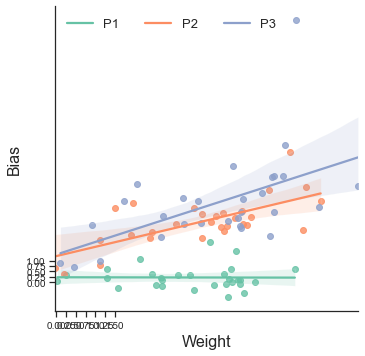

In [179]:
# in this plot, we can see how the best participants (those with higher weight) were more biased in 2nd a 3rd presentation
# to answer consistent with previous decision
sns.lmplot(x='weight', y='bias', data = bias, fit_reg = True, hue = 'nrep', legend = False, palette='Set2')

plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 10); plt.xticks(np.arange(0, 1.6, step=0.25), fontsize = 10)

plt.legend(loc='upper left', frameon=False,labels=['P1', 'P2', 'P3'], fontsize=13, title_fontsize=14, ncol=3); plt.ylabel('Bias', fontsize = 16); plt.xlabel('Weight', fontdict={'size':16}); 
#plt.savefig('biasvsweightEND.png')

In [180]:
#He tenido problemas para saber qué estadístico era el mejor 
#para mrar si había diferencias significativas en el plot anterior/ He probado diferentes estadísticos...

mdf = smf.mixedlm("bias ~ weight * C(nrep)", bias, groups = bias["npar"]).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM   Dependent Variable:   bias     
No. Observations:    87        Method:               REML     
No. Groups:          29        Scale:                0.9412   
Min. group size:     3         Log-Likelihood:       -135.8974
Max. group size:     3         Converged:            Yes      
Mean group size:     3.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.490    0.552  0.887 0.375 -0.592  1.572
C(nrep)[T.1]         0.874    0.616  1.418 0.156 -0.334  2.082
C(nrep)[T.2]         0.861    0.625  1.378 0.168 -0.364  2.087
weight              -0.077    0.149 -0.516 0.606 -0.368  0.215
weight:C(nrep)[T.1]  0.454    0.160  2.847 0.004  0.142  0.767
weight:C(nrep)[T.2]  0.630    0.157  4.023 0.000  0.323  0.937
Group Var            0.431    0.265                           
==============================================================

"""

In [181]:
mod = ols(formula='weight ~ bias * nrep', data=bias)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     8.564
Date:                Fri, 29 May 2020   Prob (F-statistic):           5.10e-05
Time:                        14:58:08   Log-Likelihood:                -161.01
No. Observations:                  87   AIC:                             330.0
Df Residuals:                      83   BIC:                             339.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2184      0.306     10.509      0.0

In [182]:
# we make a similar analyses than before, but know we stimated biased between previous answer correct/incorrect
# we wanted to stimate if participants were more biased when the previous answer was correct or incorrect
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['pre_correct','npar', 'pre_deci']).apply(log_reg_fit, formula)
log_data.reset_index(inplace = True)

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0)
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

pre_correct  npar  pre_deci  level_3  intercept    weight  pre_intercept  \
0            0   1.0         0        0  -0.908199  4.548749       0.000000   
1            0   1.0         1        0   1.179351  3.325012      -0.908199   
2            0   2.0         0        0  -1.027192  6.392084       1.179351   
3            0   2.0         1        0   1.708939  2.354398      -1.027192   
4            0   3.0         0        0  -0.929194  2.153715       1.708939   

       bias  
0 -0.908199  
1  2.087550  
2 -2.206543  
3  2.736130  
4 -2.638133

In [183]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['pre_correct','npar']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['pre_correct', 'npar', 'intercept']]
log_data2.head()

bias2 = log_data[['pre_correct', 'bias', 'pre_deci', 'npar']]
bias2 = bias2.loc[(bias2.pre_deci == 1),:]
bias2 = bias2[['bias']]
bias2.reset_index(drop=True, inplace=True)
bias2.head()

bias2 = pd.concat([log_data2, bias2], axis=1)
biaspre_correct = bias2
biaspre_correct.head()

pre_correct  npar  level_2  intercept    weight      bias
0            0   1.0        0   0.188809  0.971825  2.087550
1            0   2.0        0   0.760183  0.156718  2.736130
2            0   3.0        0   0.035170  0.008780  1.937578
3            0   4.0        0   0.530953  1.129131  2.151531
4            0   5.0        0   1.049514  0.508915  2.176719

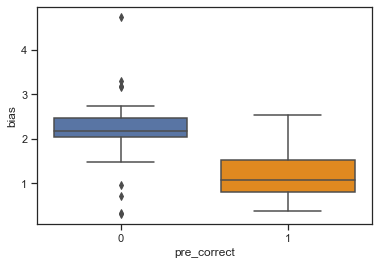

In [184]:
# Next, I will plot if there is more bias after an error, or after correct answers

# habría que hacer un plot mejor, la única cosa es que no me deja hacer el log_reg_fit poniendo nrep. Porque no admite más variables
plt.plot(figsize = (7,10))

sns.boxplot(x='pre_correct', y='bias', data =bias2)

In [185]:
#The same boxplot with Plotly

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

dat = biaspre_correct.loc[(biaspre_correct.pre_correct == 0),:]
fig.add_trace(go.Box(
    y=dat['bias'],
    boxpoints='all',
    whiskerwidth=0.5,
    width = 0,
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#FFDCA2', # sand
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.1,
    name='Incorrect', # Stimuli followed by another similar in orientation
    marker_color='#FFDCA2')) # sand
#0A4893

dat = biaspre_correct.loc[(biaspre_correct.pre_correct == 1),:]
fig.add_trace(go.Box(
    y=dat['bias'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.5,
    width = 0,
    marker=dict(
        color='#4385BB', #dark blue #4385BB  #355C7D
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.1, 
    name='Correct', # Stimuli followed by another very different in orientation
    marker_color='#4385BB' #dark blue
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Intercept'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0], ticktext=[' ', '2'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.1, 0.3, 0.5, 0.7], ticktext=['0.1', '0.3', '0.5', '0.7'])


fig.update_layout(
    legend=dict(
        x=0.62,
        y=0.9,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=18,
            color="#54636D"
        )))

fig.update_layout(
    yaxis_title="Bias",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)

fig.show()

In [186]:
#Checking statistical differences in bias when previous was correct or not
pg.rm_anova(dv = 'bias', within = ['pre_correct'], subject = 'npar', data=bias2, detailed = True, correction = True)

# more bias when previous was incorrect, differences were significant

Source      SS  DF      MS       F        p-unc    np2 eps
0  pre_correct  15.663   1  15.663  51.184  8.72812e-08  0.646   1
1        Error   8.569  28   0.306       -            -      -   -

Si son solo dos condiciones no se hace ANOVA, se hace t-test. Porque queríamos mirar si hay diferencias aquí? Qué significa que si las haya?

In [187]:
# we make a similar analyses than before, but know we stimated biased between previous answer correct/incorrect
# we wanted to stimate if participants were more biased when the previous answer was correct or incorrect

# i tried to incorporate nrep, but until now it is not working
# here it is the best try, but it provides results that seems contradictory to me compared with the previous plot
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['pre_correct','nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_data.reset_index(inplace = True)

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0)
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

pre_correct  nrep  pre_deci  level_3  intercept    weight  pre_intercept  \
0            0     0         0        0   0.258611  1.378760       0.000000   
1            0     0         1        0   0.588493  2.205798       0.258611   
2            0     1         0        0  -1.281846  2.874498       0.588493   
3            0     1         1        0   2.041389  3.257077      -1.281846   
4            0     2         0        0  -1.615671  3.056801       2.041389   

       bias  
0  0.258611  
1  0.329883  
2 -1.870339  
3  3.323235  
4 -3.657060

In [188]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['pre_correct','nrep']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['pre_correct', 'nrep', 'intercept']]
log_data2.head()

bias2 = log_data[['pre_correct', 'bias', 'pre_deci', 'nrep']]
bias2 = bias2.loc[(bias2.pre_deci == 1),:]
bias2 = bias2[['bias']]
bias2.reset_index(drop=True, inplace=True)
bias2.head()

bias2 = pd.concat([log_data2, bias2], axis=1)
bias2.head()

pre_correct  nrep  level_2  intercept    weight      bias
0            0     0        0   0.466666  1.895981  0.329883
1            0     1        0   0.414113 -0.902802  3.323235
2            0     2        0   0.399698 -1.307749  3.924410
3            1     0        0   0.554940  2.784040  0.272041
4            1     1        0   0.406485  4.983649  4.962317

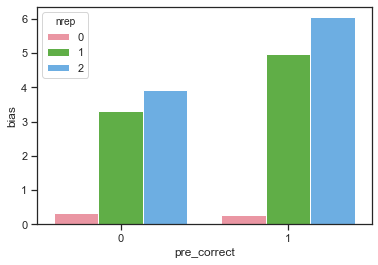

In [189]:
#I don't think this is correct, because (I think)it is contradictory with the last plot. And I forced the code to give a result.
plt.plot(figsize = (7,10))

sns.barplot(x='pre_correct', y='bias', hue='nrep', data =bias2)

aqui parece que hay mas bias cuando en el trial anterior la gente respondia correctamente. Sin embargo en la figura de arriba (naranja y azul bloxplot) parecia al reves. Por qué?

### Data anlysis and plots by stimuli

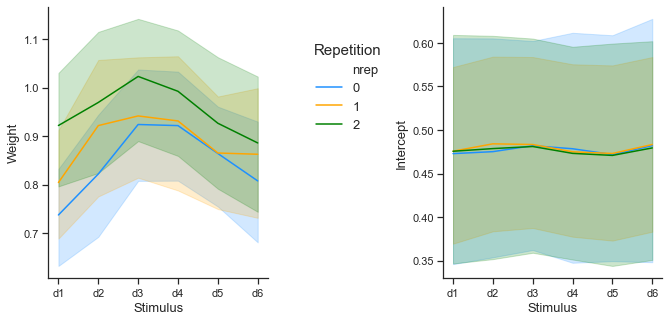

In [190]:
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.8) #wspace sirve para marcar la separación entre los dos plots 
#con un valor negativo te cargas el primer plot

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()


plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
#plt.legend(frameon=False)
plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56
                          , 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
sns.despine(top=True)
#plt.savefig('stim_wewight&intercept.png')

In [191]:
print('ANOVA to check if there are differences in the how stimuli are weighted depending on their position')
aov_recency = AnovaRM(log_regstim_params, 'weight', 'npar', within = ['nrep', 'stim']).fit()
print(aov_recency)
print('ANOVA to check if there are differences at the intercept depending on the stimuli position')
aov_recencI = AnovaRM(log_regstim_params, 'intercept', 'npar', within = ['nrep', 'stim']).fit()
print(aov_recencI)
print('Multiple Comparisons after significant ANOVA')
com_recency = sp.posthoc_ttest(log_regstim_params, val_col='weight', group_col='stim')
print(com_recency)
com_rec_rep = sp.posthoc_ttest(log_regstim_params, val_col='weight', group_col='nrep')
print(com_rec_rep)

ANOVA to check if there are differences in the how stimuli are weighted depending on their position
                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
nrep      10.0938  2.0000  56.0000 0.0002
stim       2.2768  5.0000 140.0000 0.0502
nrep:stim  1.3382 10.0000 280.0000 0.2096

ANOVA to check if there are differences at the intercept depending on the stimuli position
                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
nrep       0.0048  2.0000  56.0000 0.9952
stim       0.3906  5.0000 140.0000 0.8546
nrep:stim  0.7277 10.0000 280.0000 0.6982

Multiple Comparisons after significant ANOVA


NameError: name 'sp' is not defined

In [ ]:
#logistic regression to estimate weight and intercept parameters with previous decision by stimuli
formula = "deci ~ dv"

log_regstim_params_preD = dflong.groupby(['npar','nrep', 'stim', 'pre_deci']).apply(log_reg_fit, formula)
log_regstim_params_preD.reset_index(inplace = True)

dat = log_regstim_params_preD

dat.insert(7, 'pre_weight', 0)
dat['pre_weight'] = dat['weight']
dat['pre_weight'] = dat['pre_weight'].shift(1, fill_value = 0)

dat.insert(8, 'w_dif', 0)
dat['w_dif'] = dat['weight'] - dat['pre_weight']

dat.insert(9, 'pre_int', 0)
dat['pre_int'] = dat['intercept']
dat['pre_int'] = dat['pre_int'].shift(1, fill_value = 0)

dat.insert(10, 'i_dif', 0)
dat['i_dif'] = dat['intercept'] - dat['pre_int']

In [ ]:
# it plots weight and intercept depending on the previous decision, when previous was cardinal by stimuli
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.2) #wspace antes 0.5

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 0),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 0),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
legend =plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56, 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
legend.remove()
sns.despine(top=True)

In [ ]:
# weight
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
#aov_log_preg_preD_car = AnovaRM(dat, 'weight', 'npar', within = ['nrep', 'stim']).fit()
print('How stimuli are weighted depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was cardinal')
pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

In [ ]:
# intercept
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
#aov_log_preg_preDI_car = AnovaRM(dat, 'intercept', 'npar', within = ['nrep', 'stim']).fit()
print('Intercept changes depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was       cardinal')

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

In [ ]:
# it plots weight and intercept depending on the previous decision, when previous was diagonal by stimuli
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.2) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 1),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 1),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
legend=plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56, 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
legend.remove()
sns.despine(top=True)

In [ ]:
# weight

dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];
#aov_log_preg_preD_diag = AnovaRM(dat, 'weight', 'npar', within = ['nrep', 'stim']).fit()
print('How stimuli are weighted depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was diagonal')

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

In [ ]:
# intercept

dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];

#aov_log_preg_preDI_diag = AnovaRM(dat, 'intercept', 'npar', within = ['nrep', 'stim']).fit()
print('Intercept changes depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was       diagonal')

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

#### Bins intercept and weight plots

In [ ]:
formula = "deci ~ dv"

log_regbinned_params = dflong.groupby(['npar','nrep', 'bins', 'cond']).apply(log_reg_fit, formula)
log_regbinned_params.reset_index(inplace = True)
dat = log_regbinned_params

plt.subplots(ncols=2, figsize=(10, 5))
plt.subplots_adjust(wspace = 0.25)

plt.subplot(1, 2, 1) 
sns.lineplot(x="bins", y="weight",
             hue="nrep",
             palette= ["dodgerblue", "orange", "green"],
             data=dat)
plt.subplot(1, 2, 2)  
sns.lineplot(x="bins", y="intercept",
             hue="nrep",
             palette= ["dodgerblue", "orange", "green"],
             data=dat)

ANOVAS AQUI?